In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf

from datetime import datetime

In [2]:
# Get the stock quote
CRYPTO = 'ETH-USD'
#  Get the data
df = yf.download(tickers=CRYPTO, period='1mo', interval='5m')
# Show teh data
df = df[-3000:]


[*********************100%%**********************]  1 of 1 completed


In [3]:
# dataframe consists 7 fields: Date, Open, High, Low, Close, Adj Close, Volume 
# Create a new dataframe with only the 'Close' column 
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .80 ))

training_data_len

2400

In [4]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [5]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.10699558, 0.12149105, 0.11897903, 0.12342095, 0.12274356,
       0.12889092, 0.13785506, 0.13965777, 0.14209197, 0.14800987,
       0.15200634, 0.18336014, 0.19767205, 0.19312039, 0.17263669,
       0.17926939, 0.17881547, 0.17395056, 0.16316626, 0.15914683,
       0.13766052, 0.14138016, 0.13404414, 0.13753133, 0.14381336,
       0.13214566, 0.11785571, 0.09795363, 0.10637057, 0.11658274,
       0.11477206, 0.1118974 , 0.11441042, 0.11404579, 0.11103047,
       0.10270431, 0.10897187, 0.11921597, 0.1189491 , 0.10178749,
       0.10124478, 0.10108167, 0.09962664, 0.10869154, 0.10415735,
       0.10388499, 0.0891072 , 0.09344187, 0.0896973 , 0.10043072,
       0.09742838, 0.10187079, 0.11091225, 0.11487132, 0.11477305,
       0.11883787, 0.11587393, 0.11711298, 0.12052635, 0.11049425])]
[0.12234351657176745]

[array([0.10699558, 0.12149105, 0.11897903, 0.12342095, 0.12274356,
       0.12889092, 0.13785506, 0.13965777, 0.14209197, 0.14800987,
       0.15200634, 0.18336014, 0.19

In [6]:
x_train.shape

(2340, 60, 1)

In [7]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

d:\University Education\Second semester 2023 - 2024\pm\Source\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2340/2340 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - loss: 0.0024


In [8]:
# Create the testing data set
# Create a new array containing the last 60 elements of scaled values 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


11.32929392991952

C:\Users\Dell\AppData\Local\Temp\ipykernel_19072\2785214076.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


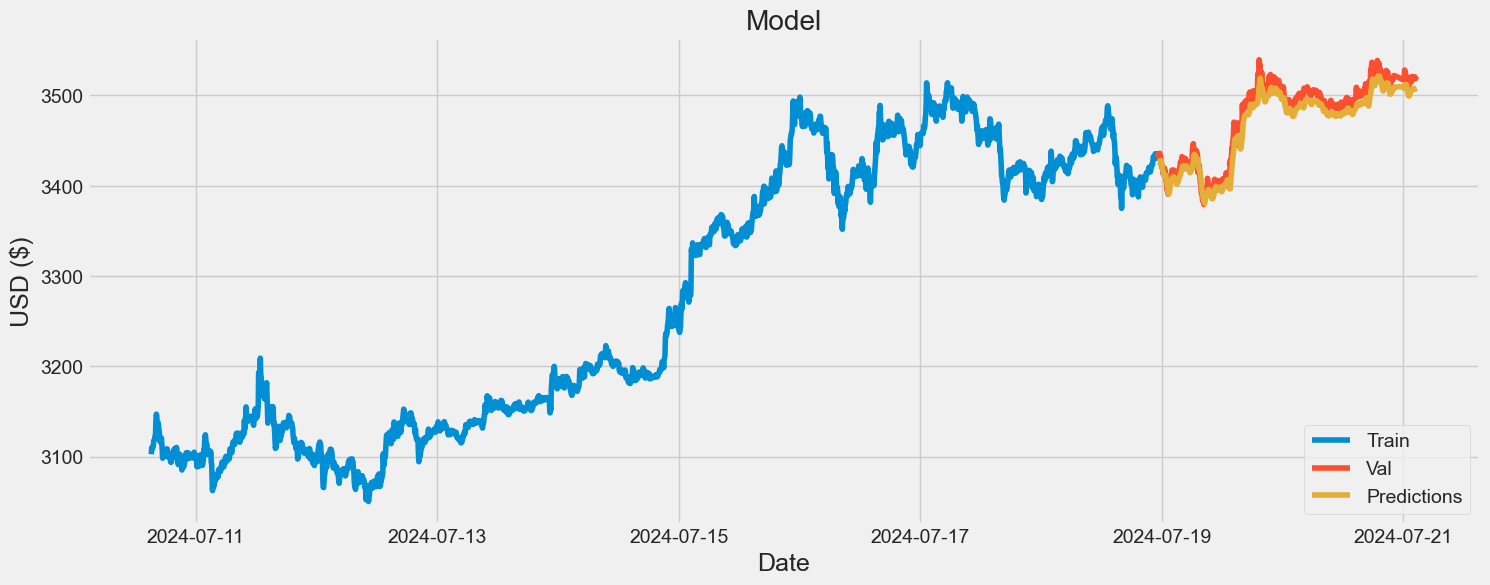

In [9]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [10]:
# save the model
model.save(f"./models/{CRYPTO}.h5")

# save the scaler
import joblib
joblib.dump(scaler, f"./models/{CRYPTO}.joblib")

['./models/ETH-USD.joblib']